#### Import Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#### Importing The Dataset

In [2]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [3]:
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


#### Feature Scaling

In [4]:
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

#### Initialize The Self-Organizing Map (SOM) using the MiniSom package

In [5]:
som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)

#### Initialize Weights & Train SOM

In [6]:
som.random_weights_init(X)
som.train_random(X, num_iteration=100)

#### Visualize Self-Organizing Map With Pylab

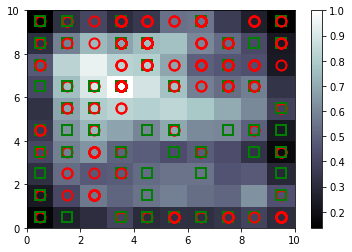

In [7]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2,
        )
show()

#### Collecting Customers Identified as Fraudulent by the SOM

In [9]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[3,6], mappings[2,6]), axis = 0)
frauds = sc.inverse_transform(frauds)

#### Create Dependent Variable (is_fraud) to Train the ANN

In [10]:
customers = dataset.iloc[:, 1:].values
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1

#### Feature Scaling

In [11]:
sc = StandardScaler()
customers = sc.fit_transform(customers)

#### Creating and fitting the Artificial Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [14]:
classifier = Sequential()
classifier.add(Dense(units = 2, kernel_initializer='uniform', activation = 'relu', input_dim = 15))
classifier.add(Dense(units = 1, kernel_initializer='uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
690/690 [==============================] - 2s 3ms/step - loss: 0.5139 - acc: 0.9174
Epoch 2/2
690/690 [==============================] - 1s 2ms/step - loss: 0.2359 - acc: 0.9174


#### Rank Customers Based on Highest Probability of Fraud

In [31]:
y_pred = classifier.predict(customers)
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

In [32]:
for i in range(0,10):
    print(y_pred[i])

[1.56214230e+07 9.89407301e-04]
[1.5799785e+07 1.1074841e-03]
[1.57250280e+07 4.65214252e-03]
[1.56548590e+07 4.67094779e-03]
[1.57063940e+07 6.02194667e-03]
[1.57280100e+07 7.83520937e-03]
[1.55858550e+07 8.12020898e-03]
[1.57238270e+07 8.48031044e-03]
[1.57319890e+07 1.00204349e-02]
[1.56024560e+07 1.04206204e-02]
